In [1]:
n =4

In [5]:
dir(n)

['__abs__',
 '__add__',
 '__and__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 '__xor__',
 'bit_length',
 'conjugate',
 'denominator',
 'from_bytes',
 'imag',
 'numerator',
 'real',
 'to_bytes']

In [1]:

# import logging
 
# logging.basicConfig(filename = 'file.log',
#                     level = logging.DEBUG,
#                     format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')
 
# logging.debug('Debug message')
# logging.info('Info message')
# logging.warning('Warning message')
# logging.error('Error message')
# logging.critical('Critical message')

Draw the nano particles with its boundaries
# GET BOUNDARY OF PATCHES

In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random 
list_numbers = random.choices([-1,1], k=20) 
import pdb
import copy
from PIL import Image
import json
import cv2

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_annotation(img_name, anno_dir):
    json_path = anno_dir # + img_name + ".json"
    f = open(json_path)
    data = json.load(f)
    
    try:
        dict_ = list(data.values())[0]['regions']
    except TypeError:
        # TypeError: string indices must be integers
        # the format of the annotations are incorrect
        return np.tile(np.nan, (1,4))
        
    if not bool(dict_):
        # pdb.set_trace()
        return np.tile(np.nan, (1,4))
    
    anno = np.zeros((len(dict_), 4))
    anno_circle = np.zeros((len(dict_), 3))

    c = 0
    for key, value in dict_.items():
        # print(key, dict_[key]['shape_attributes']['cx'])
        cx = dict_[key]['shape_attributes']['cx']
        cy = dict_[key]['shape_attributes']['cy']
        r = dict_[key]['shape_attributes']['r']

        # anno[c] = np.array([cx-r, cy-r, cx+r, cy+r])
        anno_circle[c] = np.array([cx, cy, r])
        c+= 1

    return anno_circle

In [3]:
def get_anno_of_patch(anno_circle, x0,y0,x1,y1):

    cond0 = anno_circle[:,0] < x0
    cond1 = anno_circle[:,0] > x1
    cond2 = anno_circle[:,1] < y0
    cond3 = anno_circle[:,1] > y1

    check = cond0 | cond1 | cond2 | cond3
    
    anno_circle_patch = anno_circle[np.logical_not(check)]

    return anno_circle_patch

In [4]:
def to_patch_coord(patch_anno,W_patch,H_patch):
    # do with 2D array 
    
    x_patch_anno = np.array([patch_anno[:,0]])
    x_patch_anno = np.where(x_patch_anno < W_patch, x_patch_anno, x_patch_anno-W_patch)
    y_patch_anno = np.array([patch_anno[:,1]])
    y_patch_anno = np.where(y_patch_anno < H_patch, y_patch_anno, y_patch_anno-H_patch)
    

    r_patch_anno = np.array([patch_anno[:,2]])

    # pdb.set_trace()
    
    converted_patch_anno = (np.concatenate((x_patch_anno, y_patch_anno, r_patch_anno), axis=0)).T      
    
    return converted_patch_anno

In [9]:
    
def get_cir_patch(file):

    input = file.split("/")[-1]
    im_name = "_".join(input.split("_")[:-1]) + '.tiff'
    print(im_name)

    im_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/PRAM_annotation/combined/"
    anno_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/PRAM_annotation/combined_json/"
    im = Image.open(im_dir + im_name)
    # plt.imshow(im)
    imarray = np.array(im)

    H, W = imarray.shape

    patch_idx = int((input.split("_")[-1]).split(".")[0])
    

    center_x = int(W/2)
    center_y = int(H/2)
    patches = [np.array([0,0,center_x, center_y]),np.array([center_x, 0, W, center_y]), np.array([0,center_y,center_x, H]), np.array([center_x, center_y, W, H])] 

    x0,y0,x1,y1 = patches[patch_idx]

    anno_circle = get_annotation(im_name, anno_dir + im_name.split(".")[0] + ".json")

    if np.isnan(anno_circle).all():
        # pdb.set_trace()
        return None, None


    anno_circle_patch = get_anno_of_patch(anno_circle, x0,y0,x1,y1)
    converted_patch_coor = to_patch_coord(anno_circle_patch, center_x, center_y)
        

    if np.isnan( anno_circle_patch).all():
            # there is no annotation that lies in this corner of the image
        return None
    
    return converted_patch_coor, anno_circle
            

In [6]:
def draw(file):
    image = cv2.imread(file)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # cv2.imshow("1", image_gray)
    plt.imshow(image_gray, cmap='gray')


In [7]:

def plot_circle_patch(file):
    anno_circle, _ = get_cir_patch(file)
    image = cv2.imread(file)
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap='gray')

    # mask = np.zeros((img_gray.shape[:2]),dtype=np.uint8)

    for i in range(len(anno_circle)):
        x, y, radius = anno_circle[i]

        cv2.circle(img_gray, center=(int(x), int(y)), radius=int(radius), color=(120), thickness= 1)

    plt.imshow(img_gray, cmap='gray')
    
    norm = True
    if norm:
        img_gray = img_gray - np.min(img_gray)/ np.max(img_gray) - np.min(img_gray)
        for i in range(len(anno_circle)):
            x, y, radius = anno_circle[i]

            cv2.circle(img_gray, center=(int(x), int(y)), radius=int(radius), color = (0.5), thickness= 1)

        plt.imshow(img_gray)


Tianle40min-0am375-aqDMSO-DSC.tiff


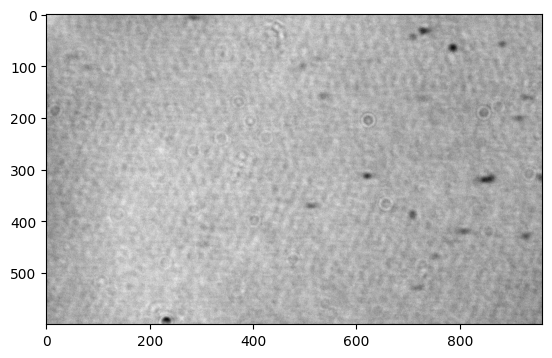

In [10]:
file = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/Tianle40min-0am375-aqDMSO-DSC_3.png"
anno_circle_patch, anno_circle = get_cir_patch(file)
draw(file)

Tianle40min-0am375-aqDMSO-DSC.tiff


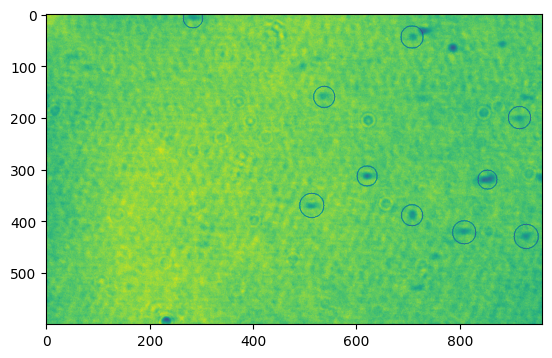

In [11]:
plot_circle_patch(file)

In [13]:
pred = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/gray_pred_inv/fold0/Tianle40min-0am375-aqDMSO-DSC_3.png"

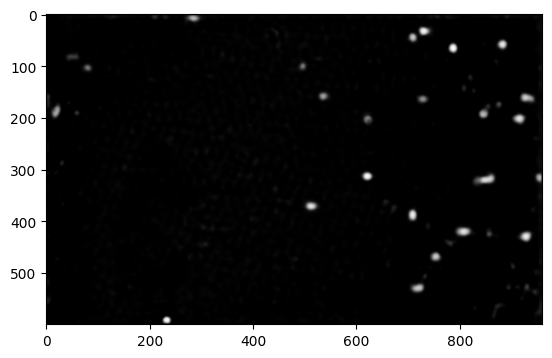

In [16]:
plt.imshow(Image.open(pred), cmap='gray')

""""


GET ANNOTATION OF FULL SIZE IMAGES

""""

In [10]:
# file = "/home/huyentn2/huyen/project/data_nano/PRAM_Images_Annotation/combined/Tianle1ng_2.tiff"
file = "/home/huyentn2/huyen/project/data_nano/PRAM_Images_Annotation/combined/Tianle40min-1fm375-aqDMSO-DSC.tiff"

In [15]:
def plot_circle_full(file):
    anno_dir = "/home/huyentn2/huyen/project/data_nano/PRAM_Images_Annotation/combined_json/"
    anno_name = (file.split("/")[-1]).split(".")[0] + ".json"
    anno_circle = get_annotation("", anno_dir +  anno_name)
    image = cv2.imread(file)
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap='gray')

    # mask = np.zeros((img_gray.shape[:2]),dtype=np.uint8)

    for i in range(len(anno_circle)):
        x, y, radius = anno_circle[i]

        cv2.circle(img_gray, center=(int(x), int(y)), radius=int(radius), color=(120), thickness= 1)

    plt.imshow(img_gray, cmap='gray')
    print("len", len(anno_circle))
    norm = True
    if norm:
        img_gray = img_gray - np.min(img_gray)/ np.max(img_gray) - np.min(img_gray)
        for i in range(len(anno_circle)):
            x, y, radius = anno_circle[i]

            cv2.circle(img_gray, center=(int(x), int(y)), radius=int(radius), color = (0.5), thickness= 1)

        plt.imshow(img_gray)

len 1040


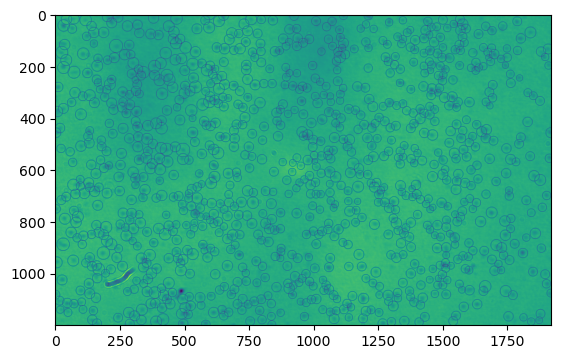

In [16]:
plot_circle_full(file)

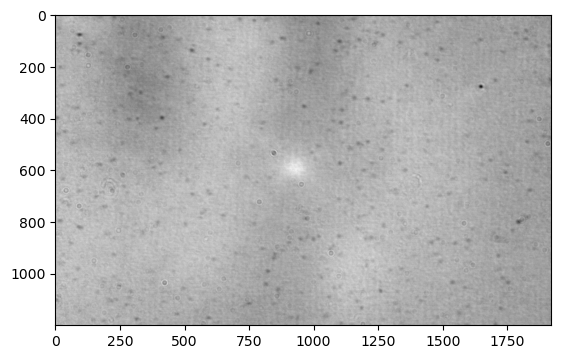

In [106]:
image = cv2.imread(file)
img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

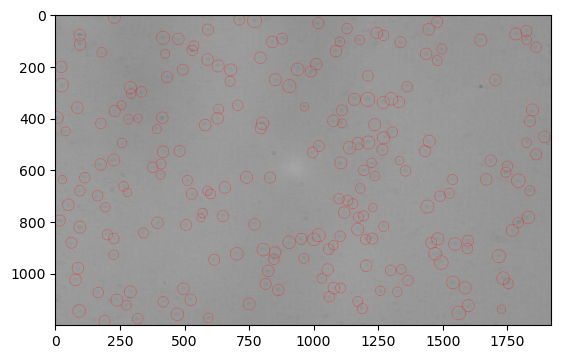

In [93]:
for i in range(len(anno_circle)):
    x, y, radius = anno_circle[i]

    cv2.circle(image, center=(int(x), int(y)), radius=int(radius), color = (255, 0, 0), thickness= 1)

plt.imshow(image)

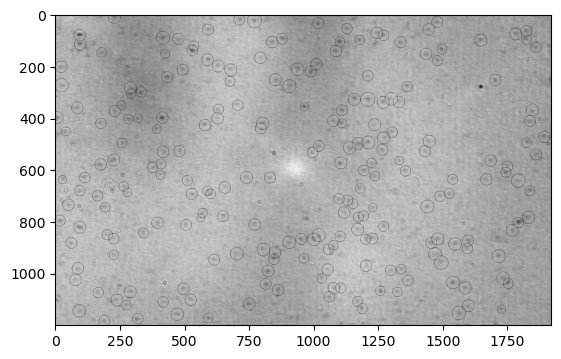

In [113]:
for i in range(len(anno_circle)):
    x, y, radius = anno_circle[i]

    cv2.circle(img_gray, center=(int(x), int(y)), radius=int(radius), color = (120), thickness= 1)

plt.imshow(img_gray, cmap = 'gray')